In [11]:
from paperswithtopic.config import load_config
from paperswithtopic.inference import inference, revert2class

from IPython.display import clear_output

In [2]:
cfg = load_config()
cfg.use_saved = False
cfg.pre_embed = False
cfg.use_bert_embed = False

In [31]:
papers = [
 'perch 2.0 : fast and accurate gpu-based perception via search for object pose estimation',
 'unsupervised cross-modal alignment for multi-person 3d pose estimation',
 'appearance consensus driven self-supervised human mesh recovery',
 'plg-in: pluggable geometric consistency loss with wasserstein distance in monocular depth estimation',
 'caspr: learning canonical spatiotemporal point cloud representations',
 'imagenet performance correlates with pose estimation robustness and generalization on out-of-domain data',
 'physics-based dexterous manipulations with estimated hand poses and residual reinforcement learning',
 'parts-based articulated object localization in clutter using belief propagation',
 '1-point ransac-based method for ground object pose estimation',
 'real-time sign language detection using human pose estimation',
 'safe and effective picking paths in clutter given discrete distributions of object poses',
 'dggan: depth-image guided generative adversarial networks for disentangling rgb and depth images in 3d hand pose estimation',
 'temporal-aware self-supervised learning for 3d hand pose and mesh estimation in videos',
 'mvhm: a large-scale multi-view hand mesh benchmark for accurate 3d hand pose estimation',
 'efficient human pose estimation with depthwise separable convolution and person centroid guided joint grouping',
 'unoc: understanding occlusion for embodied presence in virtual reality',
 'multi-person full body pose estimation',
 'pam:point-wise attention module for 6d object pose estimation',
 'hand-based person identification using global and part-aware deep feature representation learning',
 'automatic social distance estimation from images: performance evaluation, test benchmark, and algorithm'
]

In [32]:
y[5000:5020]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0,

In [30]:
preprocess.X_raw[5000:5020]

['perch 2.0 : fast and accurate gpu-based perception via search for object pose estimation',
 'unsupervised cross-modal alignment for multi-person 3d pose estimation',
 'appearance consensus driven self-supervised human mesh recovery',
 'plg-in: pluggable geometric consistency loss with wasserstein distance in monocular depth estimation',
 'caspr: learning canonical spatiotemporal point cloud representations',
 'imagenet performance correlates with pose estimation robustness and generalization on out-of-domain data',
 'physics-based dexterous manipulations with estimated hand poses and residual reinforcement learning',
 'parts-based articulated object localization in clutter using belief propagation',
 '1-point ransac-based method for ground object pose estimation',
 'real-time sign language detection using human pose estimation',
 'safe and effective picking paths in clutter given discrete distributions of object poses',
 'dggan: depth-image guided generative adversarial networks for 

In [23]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [25]:
cfg.model_name = 'albertclassification'
model_path = './models/20210605-2023_albertclassification/albertclassification_EP8_VALAUC89.pth'

In [26]:
cfg.vocab_size = 30562

In [75]:
from paperswithtopic.config import save_config

In [77]:
save_config(cfg, './asset/config.yml')

In [33]:
inference(cfg, papers, model_path)

Use cuda:0 as a device.
Load Albertclassification as model.
[remove_unknown] 0.0 sec 
[tokenize_papers] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[build_mask] 0.0 sec 
[preprocess_infer] 2.8 sec 
[inference] 3.3 sec 


array([[9.59664024e-03, 6.63050031e-03, 1.28576905e-03, 7.65483141e-01,
        6.44951267e-03, 1.18603930e-03, 1.58683043e-02, 3.74572538e-02,
        1.50513358e-03, 7.79866148e-03, 2.29225904e-02, 3.94904055e-02,
        5.47515638e-02, 1.68817006e-02, 1.26928454e-02],
       [2.84632610e-04, 2.49196636e-03, 1.67317851e-03, 2.74282992e-02,
        9.68290493e-03, 1.50955829e-03, 1.80748701e-02, 1.15753328e-02,
        7.86595454e-04, 4.19255719e-03, 1.63242093e-03, 3.38644274e-02,
        1.37665058e-02, 1.96346752e-02, 8.53402078e-01],
       [5.21988422e-03, 6.18660590e-03, 3.53821437e-03, 4.24811304e-01,
        8.09906796e-03, 1.06242020e-03, 6.22010184e-03, 7.83722699e-02,
        8.38335080e-04, 4.84088343e-03, 1.08027667e-01, 8.09116289e-02,
        2.45801672e-01, 9.27977357e-03, 1.67902280e-02],
       [1.18624186e-03, 1.48105994e-03, 5.99773775e-04, 8.74617100e-01,
        1.01688621e-03, 6.65659099e-05, 6.82563172e-04, 1.07968291e-02,
        1.23711026e-04, 6.68758235e-0

In [34]:
preds = _

In [72]:
field, proba = revert2class(preds, cfg)

G:\My Drive\projects\paperswithcode_nlp\paperswithtopic\inference.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  column2idx = yaml.load(f)


In [73]:
field

[['computer-vision', 'robots', 'reasoning'],
 ['time-series', 'reasoning', 'computer-vision'],
 ['computer-vision', 'robots', 'playing-games'],
 ['computer-vision', 'robots', 'miscellaneous'],
 ['computer-vision', 'time-series', 'miscellaneous'],
 ['miscellaneous', 'reasoning', 'computer-vision'],
 ['playing-games', 'reasoning', 'robots'],
 ['computer-vision', 'robots', 'reasoning'],
 ['robots', 'computer-vision', 'playing-games'],
 ['computer-vision', 'time-series', 'medical'],
 ['graphs', 'time-series', 'robots'],
 ['medical', 'adversarial', 'computer-vision'],
 ['computer-vision', 'robots', 'miscellaneous'],
 ['computer-vision', 'speech', 'audio'],
 ['computer-vision', 'robots', 'reasoning'],
 ['natural-language-processing', 'reasoning', 'time-series'],
 ['time-series', 'robots', 'computer-vision'],
 ['computer-vision', 'robots', 'miscellaneous'],
 ['medical', 'computer-vision', 'miscellaneous'],
 ['reasoning', 'time-series', 'natural-language-processing']]

In [37]:
cfg = load_config()
cfg.use_saved = False
cfg.pre_embed = False
cfg.use_bert_embed = False

In [ ]:
X, y = preprocess.pp_pipeline()
idx2word = preprocess.idx2word

In [39]:
from paperswithtopic.dataloader import get_dataloader

In [58]:
train_dataloader = get_dataloader(cfg, X, y, test=False, shuffle=True)
valid_dataloader = get_dataloader(cfg, X, y, test=True)

In [41]:
vars(train_dataloader)

{'dataset': <paperswithtopic.dataloader.PaperDataset at 0x160b84bf970>,
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': True,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 128,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x160b80d92b0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x160b80d9b80>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [42]:
train_dataloader.shuffle

AttributeError: 'DataLoader' object has no attribute 'shuffle'

In [59]:
train_labels = train_dataloader.dataset.label
valid_labels = valid_dataloader.dataset.label

In [56]:
from collections import Counter
import pandas as pd

In [61]:
train_labels = pd.Series(Counter(np.where(train_labels == 1)[1]))
valid_labels = pd.Series(Counter(np.where(valid_labels == 1)[1]))

In [64]:
dist = pd.DataFrame(
[train_labels, valid_labels], index=['Train', 'Valid']).T

<AxesSubplot:xlabel='Train', ylabel='Count'>

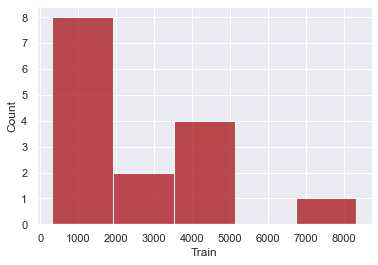

In [71]:
import seaborn as sns
sns.set_theme(context='notebook', palette='Reds_r')
sns.histplot(data=dist, x='Train')